# Using Recipe Ingredients to Categorize Cuisine

By Eka Renardi. October 15, 2015

## Introduction

This document outline my solution for solving this Kaggle Competition. Kaggle posed a challenge for predicting the category of cuisine based on its recipe ingredients. 

### Dataset

*Yummly* graciously provided the dataset for this challenge. The dataset consists of train and test set. The train set listed the cuisines, and ingredients for the cuisine.  The test set data listed just the ingredients. A sample train data set is as follows:

```
{
    "id": 25693,
    "cuisine": "southern_us",
    "ingredients": [
      "plain flour",
      "ground pepper",
      "salt",
      "tomatoes",
      "ground black pepper",
      "thyme",
      "eggs",
      "green tomatoes",
      "yellow corn meal",
      "milk",
      "vegetable oil"
    ]
}
```

Attributes:

- "id" - unique identifier
- "cuisine" - category of a cuisine
- "ingredients" - ingredients used to make the cuisine


Lets read it

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
import seaborn as sns
from nltk.stem.porter import *
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from sklearn.cross_validation import train_test_split, cross_val_score, KFold
from sklearn import metrics
from scipy.stats import sem
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances
from sklearn.datasets import make_classification
import matplotlib.pylab as pyl

sns.set_style('whitegrid')

In [2]:
df = pd.read_json('../data/train.json')

# Exploratory Statistics
In my attempt to understand the data, several exploratory statistics are constructed.

#### How many unique cuisines are there, and what are they?

('shape:', (39774, 3))
('unique cuisine count:', 20)


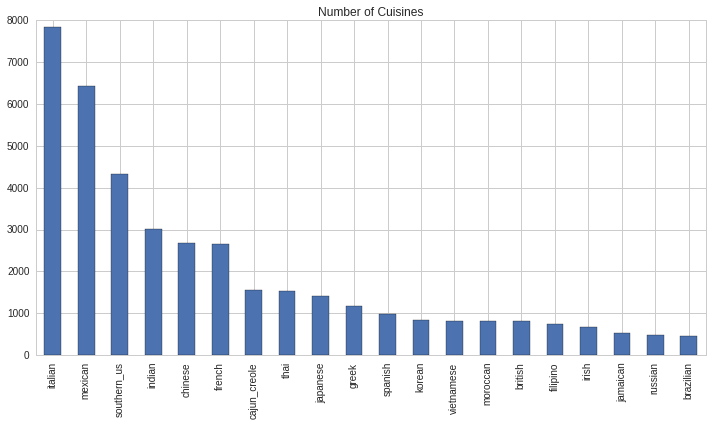

In [3]:
cuisines = df.cuisine.value_counts(sort=True)
cuisines.plot(kind="bar", figsize=(12,6), title="Number of Cuisines")
print("shape:", df.shape)
print("unique cuisine count:", len(df.cuisine.unique()))

#### What is the most often used ingredients by all cuisine? and what is the most often used ingredients for each cuisine?

In [4]:
# calculating the usage of each ingredient, and for each cuisine
cuisine_dict = defaultdict(Counter)
index_dict = defaultdict(Counter)
total_counter = Counter()
# iterate each row
for index, row in df.iterrows():
    # get the counters
    row_counter = index_dict[row.id] 
    local_counter = cuisine_dict[row.cuisine]
    # count the ingredients usage
    arr = row.ingredients
    for ingredient in row.ingredients:
        key = ingredient.lower()
        # increment each word count
        total_counter[key] += 1
        local_counter[key] += 1
        row_counter[key] += 1
    # update the counters
    cuisine_dict[row.cuisine] = local_counter
    index_dict[row.id] = row_counter
    

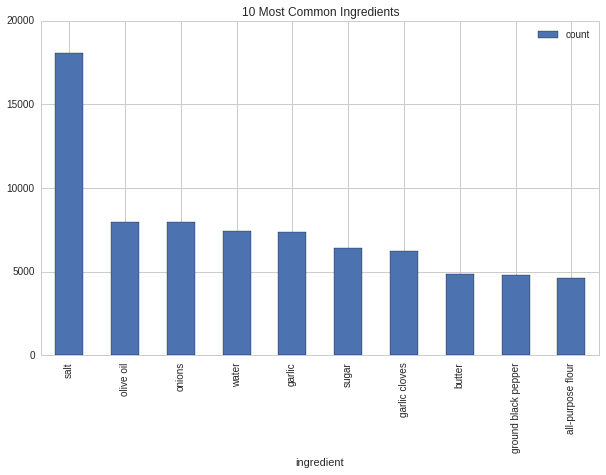

In [5]:
# plotting most common ingredients
most_common_ingredients = pd.DataFrame(total_counter.most_common(10), columns=["ingredient", "count"])
most_common_ingredients.plot(kind="bar", x="ingredient", figsize=(10,6), title="10 Most Common Ingredients")   

Let's draw a word cloud for top 100 ingredients.

/home/morita/anaconda/lib/python2.7/site-packages/PIL/ImageDraw.py:104: UserWarning: setfont() is deprecated. Please set the attribute directly instead.
  "Please set the attribute directly instead.")


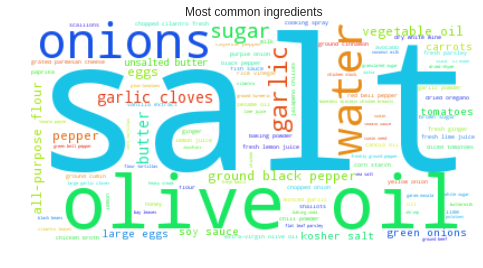

In [6]:
from wordcloud import WordCloud
wordcloudobj = WordCloud( background_color='white')
wordcloud = wordcloudobj.generate_from_frequencies(total_counter.most_common(100))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Most common ingredients")
plt.show()

Now let's look at the 100 most common ingredients used for each cuisine

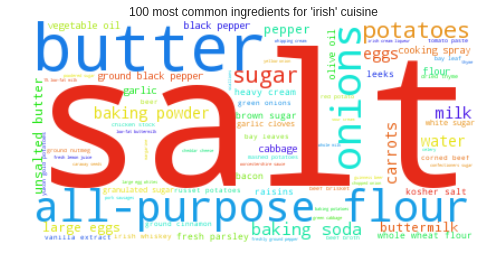

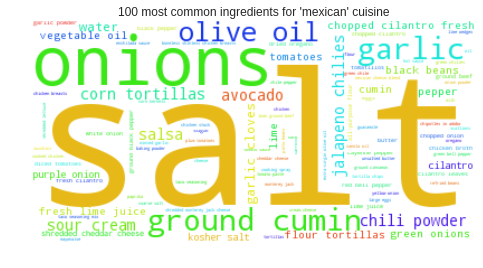

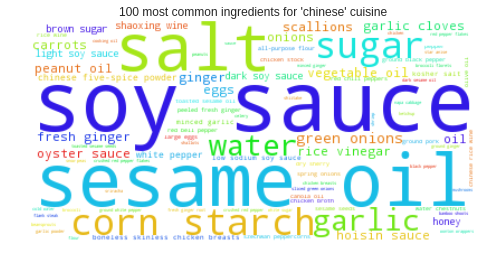

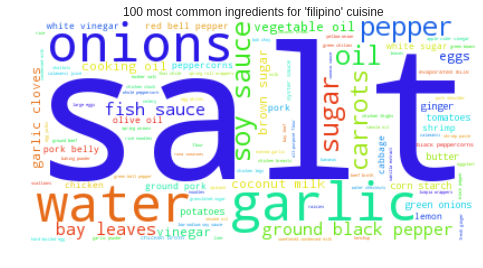

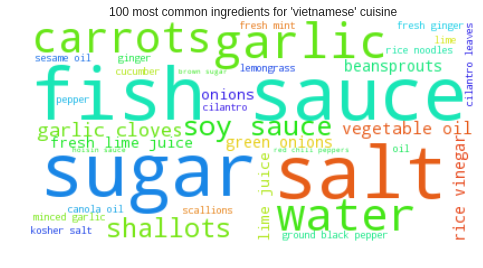

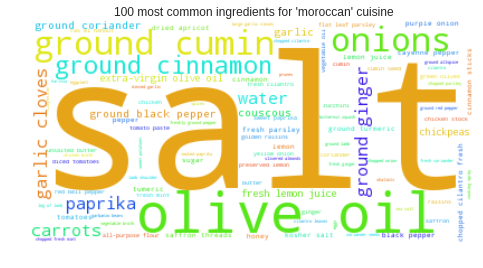

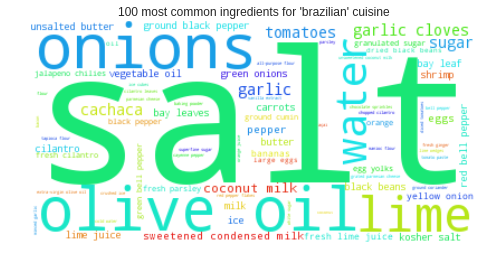

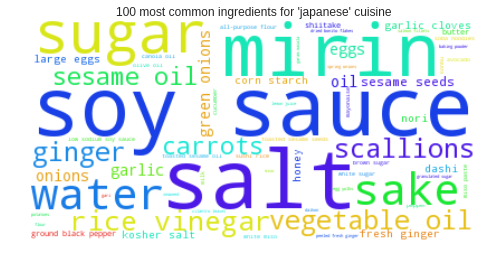

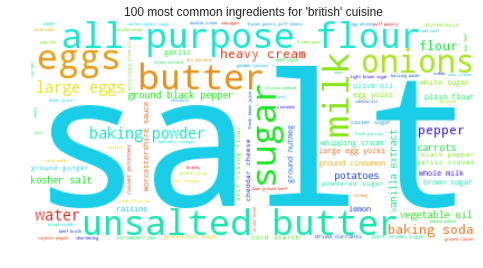

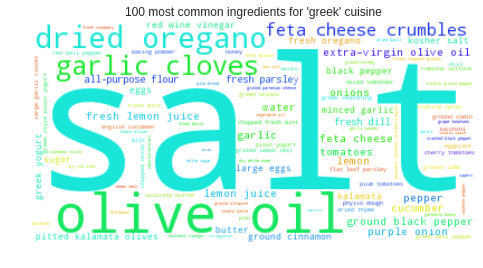

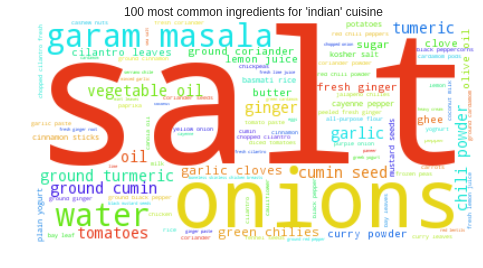

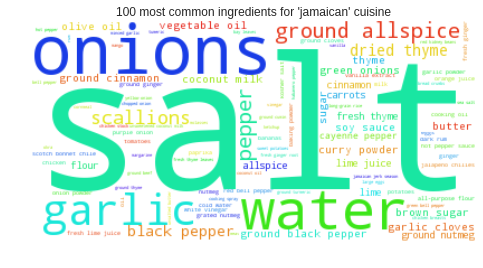

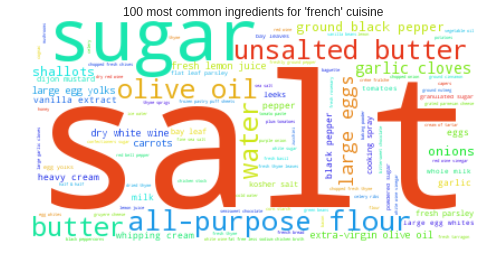

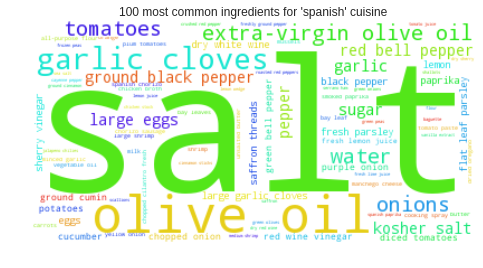

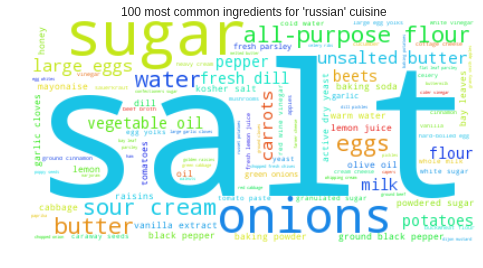

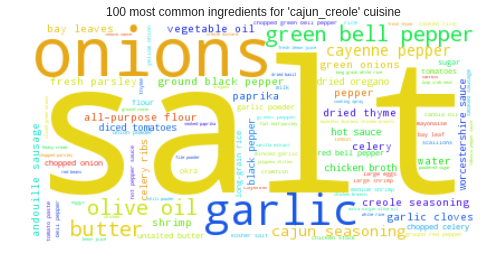

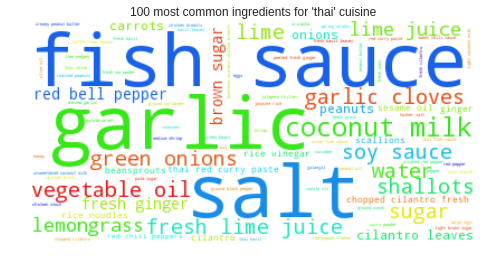

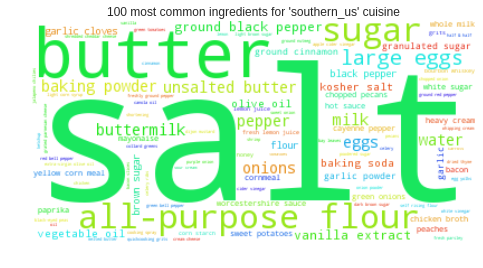

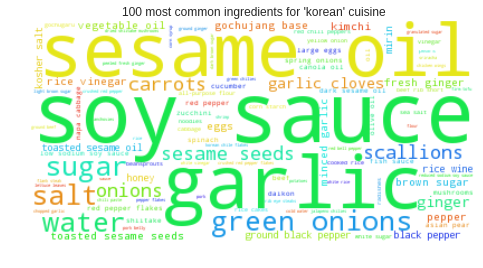

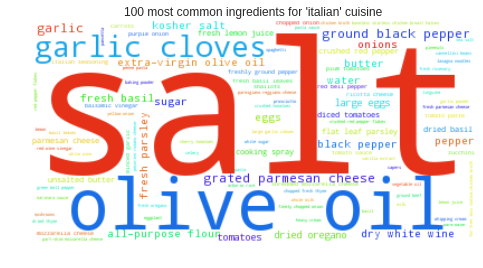

In [7]:
for key, value in cuisine_dict.iteritems():
    wc = wordcloudobj.generate_from_frequencies(value.most_common(100))
    plt.imshow(wc)
    plt.title("100 most common ingredients for '%s' cuisine" % key)
    plt.axis("off")
    plt.show()    

#### Profile of the cuisines

In [8]:
# get a vector of cuisines and ingredients
index1 = {}
for key, value in cuisine_dict.iteritems():
    index1[key] = dict(value)
df1 = pd.DataFrame.from_dict(index1, orient='index')
df1 = df1.fillna(0)
cuisine_labels = [key for key, value in df1.iterrows()]
ingredients_labels = list(df1.columns)

# calculating the table of probabilities for the cuisines
inst_count=df1.sum(axis='columns')
df1_prob= df1.div(inst_count,axis='rows')
df1_prob

,lamb stew meat,red cabbage,dijon mustard,rosemary leaves,sweetened coconut,yellow corn meal,fresh chervil,baking chocolate,hard-boiled egg,sweet potatoes,...,tart crust,calabrese sausage,smoked mozzarella,top loin steaks,quahog clams,granita,chioggia,gelato,torpedo rolls,low sodium canned chicken broth
brazilian,0.000000,0.000000,0.000675,0.000000,0.000225,0.000450,0.000000,0.000000,0.000675,0.002249,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
british,0.000000,0.000000,0.002306,0.000128,0.000000,0.000256,0.000000,0.000000,0.000769,0.000897,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cajun_creole,0.000000,0.000051,0.001538,0.000051,0.000000,0.000872,0.000051,0.000000,0.000103,0.000461,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
chinese,0.000000,0.000312,0.000219,0.000000,0.000031,0.000000,0.000000,0.000000,0.000094,0.000125,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
filipino,0.000000,0.000000,0.000132,0.000000,0.000000,0.000000,0.000000,0.000000,0.002252,0.000662,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
french,0.000038,0.000115,0.006544,0.000115,0.000000,0.000231,0.000269,0.000038,0.000577,0.000231,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
greek,0.000167,0.000084,0.001337,0.000000,0.000000,0.000000,0.000000,0.000000,0.000167,0.000084,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
indian,0.000105,0.000131,0.000183,0.000000,0.000000,0.000052,0.000000,0.000000,0.000079,0.001468,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
irish,0.000967,0.000161,0.001935,0.000322,0.000161,0.000645,0.000161,0.000161,0.000161,0.000484,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
italian,0.000026,0.000064,0.001275,0.000129,0.000000,0.000824,0.000039,0.000013,0.000077,0.000193,...,0.000013,0.000013,0.000013,0.000026,0.000013,0.000013,0.000013,0.000052,0.000013,0.000013


In [9]:
mds = MDS(n_components=2,  random_state=1)
X = mds.fit_transform(df1_prob.astype(np.float64))
x1 = X[:,0]
y1 = X[:,1]

/home/morita/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


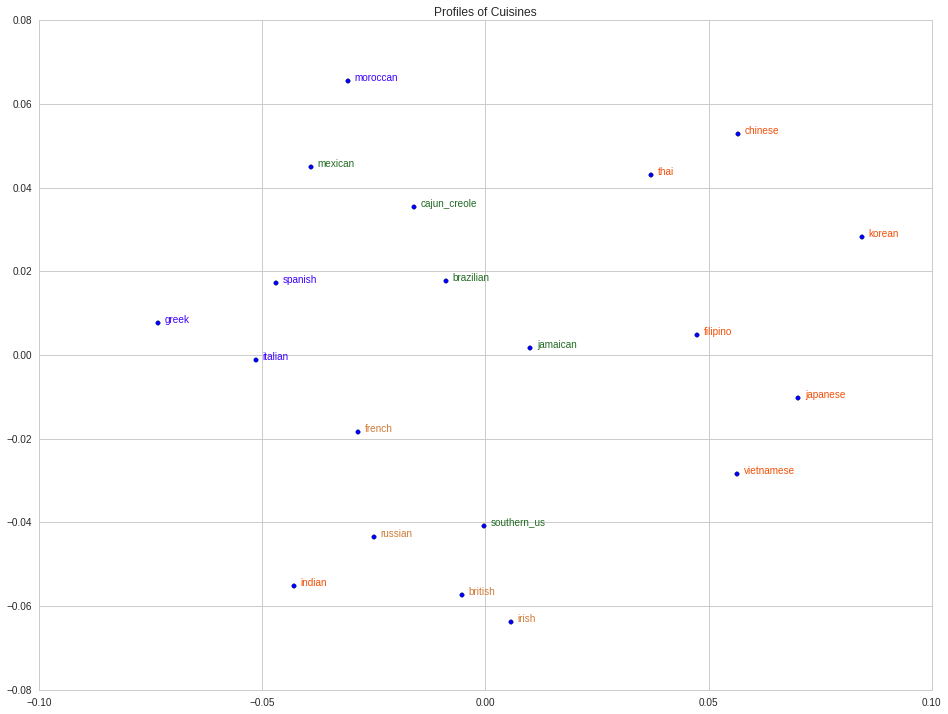

In [10]:
pyl.rcParams['figure.figsize'] = (16.0, 12.0)

fig, ax = plt.subplots()
ax=plt.scatter(x1,y1)
plt.title('Profiles of Cuisines')

colors = {
    'brazilian':    '#216b22',
    'british':      '#ce7a34',
    'cajun_creole': '#216b22',
    'chinese':      '#f24e06',
    'filipino':     '#f24e06',
    'french':       '#ce7a34',
    'greek':        '#3c00ff',
    'indian':       '#f24e06',
    'irish':        '#ce7a34',
    'italian':      '#3c00ff',
    'jamaican':     '#216b22',
    'japanese':     '#f24e06',
    'korean':       '#f24e06',
    'mexican':      '#216b22',
    'moroccan':     '#3c00ff',
    'russian':      '#ce7a34',
    'southern_us':  '#216b22',
    'spanish':      '#3c00ff',
    'thai':         '#f24e06',
    'vietnamese':   '#f24e06'
}

for i, name in enumerate(cuisine_labels):
    plt.annotate(name, (x1[i], y1[i]), color=colors[name], xytext=(7,1), textcoords='offset points')
    
plt.show()

## Model Building

### Modeling Data Preparation

In [11]:
# mapping categorical response var
df['cuisine_idx'] = df.cuisine.map({
    'brazilian':    0,
    'british':      1,
    'cajun_creole': 2,
    'chinese':      3,
    'filipino':     4,
    'french':       5,
    'greek':        6,
    'indian':       7,
    'irish':        8,
    'italian':      9,
    'jamaican':     10,
    'japanese':     11,
    'korean':       12,
    'mexican':      13,
    'moroccan':     14,
    'russian':      15,
    'southern_us':  16,
    'spanish':      17,
    'thai':         18,
    'vietnamese':   19
})

In [12]:
# combine the ingredients list into one sentence
df['ingredients_all'] = df.ingredients.apply(lambda x: " ".join(x))

In [13]:
# set the X, y
X = df['ingredients_all']
y = df['cuisine_idx']

### Model Building

Evaluate the different vectorizers: CountVectorizer, TFIDF Vectorizer and Hashing Vectorizer

In [14]:
def cross_val_validation(clf, X, y, K):
    # create a k-fold cross validation iterator of K folds
    cv = KFold(len(y), K, shuffle=True, random_state=0)
    # get the mean score, and standard error mean
    scores = cross_val_score(clf, X, y, cv=cv)
    print scores
    print ("Mean score: {0:.3f} (+/-{1:.3f})").format(np.mean(scores), sem(scores))

In [15]:
clf_1 = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB()),
])
clf_2 = Pipeline([
    ('vect', HashingVectorizer(non_negative=True)),
    ('clf', MultinomialNB()),
])
clf_3 = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

In [16]:
clfs = [clf_1, clf_2, clf_3]
for clf in clfs:
    cross_val_validation(clf, X, y, 5)

[ 0.73211816  0.72306725  0.72344437  0.72633564  0.71523762]
Mean score: 0.724 (+/-0.003)
[ 0.47818982  0.47341295  0.46360779  0.47982401  0.46806638]
Mean score: 0.473 (+/-0.003)
[ 0.68082967  0.67655563  0.67064739  0.67152734  0.66696002]
Mean score: 0.673 (+/-0.002)


Looks like the CountVectorizer has the highest score, **0.724**. Let's improve it by stemming the words. 

In [17]:
# stemming the ingredients
stemmer = PorterStemmer()
df['ingredients_stem'] = df.ingredients_all.apply(lambda x: " ".join([stemmer.stem(word.lower()) for word in x.split(" ")]))

In [18]:
# modify X using stemmed ingredients
X_stem = df['ingredients_stem']
# re-evaluate
cross_val_validation(clf_1, X_stem, y, 5)    

[ 0.73111251  0.71753614  0.72143306  0.72495286  0.71259744]
Mean score: 0.722 (+/-0.003)


Stemming does not seem to improve the score.  Let's do bigram.

In [19]:
# bigram
clf_4 = Pipeline([
    ('vect', CountVectorizer(
                ngram_range=(1, 2)
    )),
    ('clf', MultinomialNB()),
])
# re-evaluate
cross_val_validation(clf_4, X, y, 5)    

[ 0.67052168  0.66964173  0.66700189  0.66964173  0.66130249]
Mean score: 0.668 (+/-0.002)


Score does not seem to improve. Let's remove low quality words to reduce.  For this, I am going to use most common ingredients as the stop words. 

In [20]:
# total number of ingredients
len(total_counter)

6703

In [21]:
# increasing the stopwords to see if it improves the score
for ct in range(10,110,10):
    print "%d stopwords" % ct
    # get the stopwords
    stopwords = [ingredient for ingredient, cnt in total_counter.most_common(ct)]
    # new model
    clf_s = Pipeline([
        ('vect', CountVectorizer(
                    stop_words=stopwords
        )),
        ('clf', MultinomialNB()),
    ])
    # re-evaluate
    cross_val_validation(clf_s, X, y, 5)   

10 stopwords
[ 0.73299811  0.72331867  0.72583281  0.72884978  0.71687201]
Mean score: 0.726 (+/-0.003)
20 stopwords
[ 0.73614079  0.72193589  0.72532998  0.73123821  0.7178778 ]
Mean score: 0.727 (+/-0.003)
30 stopwords
[ 0.73337524  0.72470145  0.72419862  0.72960402  0.71699774]
Mean score: 0.726 (+/-0.003)
40 stopwords
[ 0.73350094  0.72495286  0.7239472   0.72822124  0.71750063]
Mean score: 0.726 (+/-0.003)
50 stopwords
[ 0.72910119  0.72294155  0.72319296  0.72633564  0.71649485]
Mean score: 0.724 (+/-0.002)
60 stopwords
[ 0.72897549  0.72319296  0.72482715  0.72595852  0.71548906]
Mean score: 0.724 (+/-0.002)
70 stopwords
[ 0.72696417  0.72118165  0.72319296  0.72369579  0.71058587]
Mean score: 0.721 (+/-0.003)
80 stopwords
[ 0.72646135  0.71979887  0.72155877  0.72357008  0.70932864]
Mean score: 0.720 (+/-0.003)
90 stopwords
[ 0.72507857  0.71829038  0.71992458  0.72168448  0.70870003]
Mean score: 0.719 (+/-0.003)
100 stopwords
[ 0.72306725  0.71816468  0.71942175  0.7204274   

With 20 stopwords seems to increase the score by 0.002. still within the error range.

In [22]:
# what are they?
total_counter.most_common(20)

[(u'salt', 18049),
 (u'olive oil', 7972),
 (u'onions', 7972),
 (u'water', 7457),
 (u'garlic', 7380),
 (u'sugar', 6434),
 (u'garlic cloves', 6237),
 (u'butter', 4848),
 (u'ground black pepper', 4785),
 (u'all-purpose flour', 4632),
 (u'pepper', 4438),
 (u'vegetable oil', 4385),
 (u'eggs', 3388),
 (u'soy sauce', 3296),
 (u'kosher salt', 3113),
 (u'green onions', 3078),
 (u'tomatoes', 3058),
 (u'large eggs', 2948),
 (u'carrots', 2814),
 (u'unsalted butter', 2782)]

In [23]:
# the model again with 20 stopwords
stopwords = [ingredient for ingredient, cnt in total_counter.most_common(20)]
clf_5 = Pipeline([
    ('vect', CountVectorizer(
                stop_words=stopwords
    )),
    ('clf', MultinomialNB()),
])
# re-evaluate
cross_val_validation(clf_5, X, y, 5)  

[ 0.73614079  0.72193589  0.72532998  0.73123821  0.7178778 ]
Mean score: 0.727 (+/-0.003)


### Model Evaluation

In [24]:
# split data to train set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [25]:
def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    
    print "Accuracy on training set:"
    print clf.score(X_train, y_train)
    print "Accuracy on testing set:"
    print clf.score(X_test, y_test)
    
    y_pred = clf.predict(X_test)
    print "Classification Report:"
    print metrics.classification_report(y_test, y_pred)
    print "Confusion Matrix:"
    print metrics.confusion_matrix(y_test, y_pred)

In [26]:
train_and_evaluate(clf_5, X_train, X_test, y_train, y_test)

Accuracy on training set:
0.746999664767
Accuracy on testing set:
0.727574416734
Classification Report:
             precision    recall  f1-score   support

          0       0.47      0.36      0.41       103
          1       0.37      0.38      0.38       189
          2       0.56      0.72      0.63       393
          3       0.71      0.87      0.78       649
          4       0.81      0.46      0.59       156
          5       0.53      0.57      0.54       683
          6       0.71      0.64      0.67       317
          7       0.86      0.89      0.88       787
          8       0.61      0.41      0.49       161
          9       0.82      0.79      0.81      2000
         10       0.84      0.53      0.65       134
         11       0.88      0.62      0.73       350
         12       0.74      0.59      0.66       198
         13       0.89      0.87      0.88      1589
         14       0.71      0.78      0.75       202
         15       0.65      0.31      0.42     

### Model Prediction

## Summary